# k-means

Goals:
- hand-code the k-means algorithm
- perform the clustering on a toy dataset
- estimate the compactness and separation
- find an optimal number of clusters using elbow method

## Import basic libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

## Create a toy dataset

In [2]:
import math

N = 100
D = 2

# data is coming from 2 normal distributions
def generate_data(n, mu1, sigma1, mu2, sigma2):
    data = np.empty([n, D], dtype=float)
    data[:, 0] = sigma1 * np.random.randn(n) + mu1
    data[:, 1] = sigma2 * np.random.randn(n) + mu2
    return data

# combine samples from 2 datasets together

data = np.empty([N, D], dtype=float)
half_N = math.floor(N / 2)
data[:half_N] = generate_data(half_N, -0.4, 0.3, -0.4, 0.3)
data[half_N:] = generate_data(half_N, 0.4, 0.3, 0.4, 0.3)
np.random.shuffle(data)

data[:5]

array([[ 0.31103893,  0.67455297],
       [ 0.34033323,  0.83217094],
       [-0.89973835, -0.45673524],
       [-0.77148582, -0.4837039 ],
       [-0.05126123,  0.01082323]])

## Plot the toy dataset

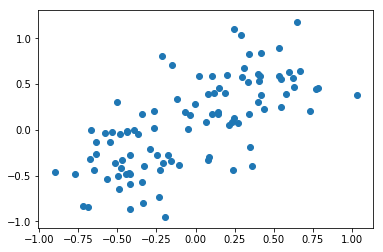

In [3]:
plt.scatter(data[:, 0], data[:, 1])

## Implement k-means

### First cluster with 2 centroids

In [4]:
def init_2_centroids():
    centroids = np.zeros([2, D], dtype=float)
    centroids[:, 0] = 1.0 - 2.0 * np.random.rand(2)
    return centroids

### Plot initial centroids

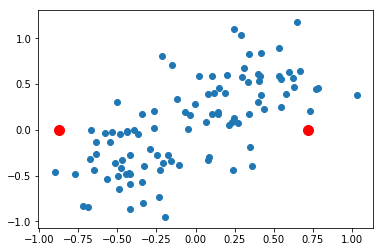

In [5]:
centroids = init_2_centroids()
plt.scatter(data[:, 0], data[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", s=100)

In [6]:
centroids

array([[-0.87439831,  0.        ],
       [ 0.71926017,  0.        ]])

### Assign every sample to 1 of k centroids

In [7]:
def assign_to_clusters(data, centroids, K):
    distances = np.empty([N, K], dtype=float)
    for n, sample in enumerate(data):
        for k, centroid in enumerate(centroids):
            dist = np.sqrt(np.square(centroid[0] - sample[0]) + np.square(centroid[1] - sample[1]))
            distances[n, k] = dist
    #print(distances)
    
    labels = np.empty([N], dtype=int)
    for n, distances in enumerate(distances):
        label = np.argmin(distances)
        labels[n] = label
    
    return labels

In [8]:
labels = assign_to_clusters(data, centroids, 2)
labels[:5]

array([1, 1, 0, 0, 1])

### Plot labels with initial centroids

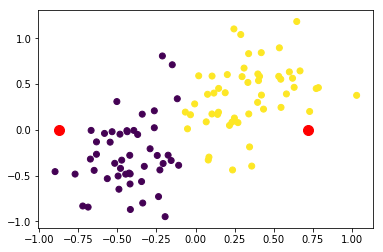

In [9]:
plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", s=100)

### Re-calculate the centroids

In [10]:
def recalculate_centroids(data, labels, K):
    centroids = np.zeros([K, D], dtype=float)
    for k in range(K):
        x = np.mean(np.ma.masked_where(labels != k, data[:, 0]))
        y = np.mean(np.ma.masked_where(labels != k, data[:, 1]))
        # print("x, y = " + str(x) + ", " + str(y))
        centroids[k] = [x, y]
    return centroids

In [11]:
centroids = recalculate_centroids(data, labels, 2)
centroids

array([[-0.42518623, -0.27656453],
       [ 0.33759982,  0.37380515]])

### Plot new position of centroids

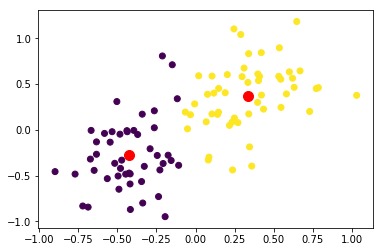

In [12]:
plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", s=100)

### Loop until centroids stop moving

In [13]:
# counter
cnt = 1

new_labels = assign_to_clusters(data, centroids, 2)
while not np.array_equal(labels, new_labels):
    print('iteration: ' + str(cnt))
    cnt = cnt + 1
    
    centroids = recalculate_centroids(data, new_labels, 2)
    labels = new_labels
    new_labels = assign_to_clusters(data, centroids, 2)

iteration: 1
iteration: 2


### Final clustering result and position of centrods

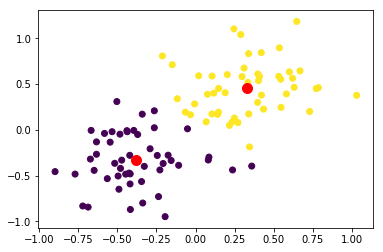

In [14]:
plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", s=100)

## Anaylize the clusters

### Compactness

In [15]:
# estimate compactness as an average distance to the centeroid
def compactness(data, labels, centroids, K):
    values = np.zeros([K], dtype=float)
    for k in range(K):
        xdist = np.ma.masked_where(labels != k, data[:, 0]) - centroids[k, 0]
        ydist = np.ma.masked_where(labels != k, data[:, 1]) - centroids[k, 1]
        avdist = np.mean(np.sqrt(np.square(xdist) + np.square(ydist)))
        values[k] = avdist
    return values

In [16]:
cluster_compactness = compactness(data, labels, centroids, 2)
cluster_compactness

array([0.33763185, 0.35251748])

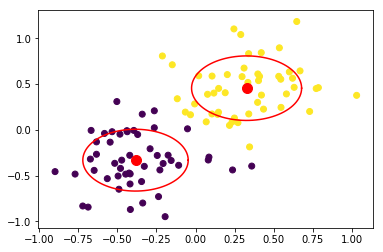

In [17]:
fig, ax = plt.subplots(1)

def draw_cluster_compactness(centroid_x, centroid_y, compactness):
    theta = np.linspace(0, 2*np.pi, 100)
    r = compactness
    x = r*np.cos(theta) + centroid_x
    y = r*np.sin(theta) + centroid_y
    ax.plot(x, y, c="red")
    
ax.scatter(data[:, 0], data[:, 1], c=labels)
ax.scatter(centroids[:, 0], centroids[:, 1], c="red", s=100)
draw_cluster_compactness(centroids[0, 0], centroids[0, 1], cluster_compactness[0])
draw_cluster_compactness(centroids[1, 0], centroids[1, 1], cluster_compactness[1])

### Separation

In [18]:
import sys

# estimate separation as a minimum distance between 2 objects in different clusters
def separation(data, labels, K):
    min_dist = sys.float_info.max
    minpair = np.empty([2, 2], dtype=float)
    for i, d1 in enumerate(data):
        for j, d2 in enumerate(data):
            if labels[i] != labels[j]:
                dist = np.sqrt(np.square(d2[0]- d1[0]) + np.square(d2[1]- d1[1]))
                if dist < min_dist:
                    min_dist = dist
                    minpair = np.array([[d1[0], d1[1]], [d2[0], d2[1]]])
            
    return min_dist, minpair

In [19]:
cluster_separation, minpair = separation(data, labels, 2)

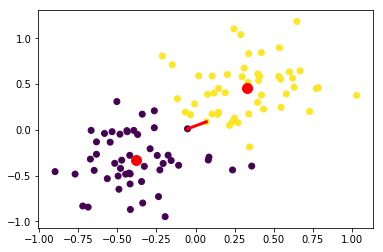

In [20]:
plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", s=100)
plt.plot(minpair[:, 0], minpair[:, 1], c="red", linewidth=3)

### Largest intra-cluster distance

In [21]:
import sys

# estimate largest intra-cluster distance
def largest_intracluster_distance(data, labels, K):
    max_dist = sys.float_info.min
    maxpair = np.empty([2, 2], dtype=float)
    
    for i, d1 in enumerate(data):
        for j, d2 in enumerate(data):
            if labels[i] == labels[j]:
                dist = np.sqrt(np.square(d2[0]- d1[0]) + np.square(d2[1]- d1[1]))
                if dist > max_dist:
                    max_dist = dist
                    maxpair = np.array([[d1[0], d1[1]], [d2[0], d2[1]]])
            
    return max_dist, maxpair

In [22]:
max_dist, maxpair = largest_intracluster_distance(data, labels, 2)

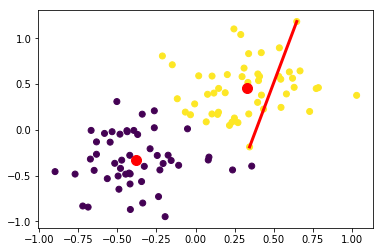

In [23]:
plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", s=100)
plt.plot(maxpair[:, 0], maxpair[:, 1], c="red", linewidth=3)

## Try different number of clusters

In [24]:
def init_centroids(K):
    centroids = 1.0 - 2.0 * np.random.rand(K, 2)
    return centroids

In [25]:
def kmeans(data, K):
    # initialize
    centroids = init_centroids(K)
    labels = np.empty([N], dtype=int)

    # counter
    cnt = 1

    new_labels = assign_to_clusters(data, centroids, K)
    while not np.array_equal(labels, new_labels):
        cnt = cnt + 1

        centroids = recalculate_centroids(data, new_labels, K)
        labels = new_labels
        new_labels = assign_to_clusters(data, centroids, K)
        
        if cnt > 100: break
        
    return labels, centroids

### 3 clusters

In [26]:
labels, centroids = kmeans(data, 3)

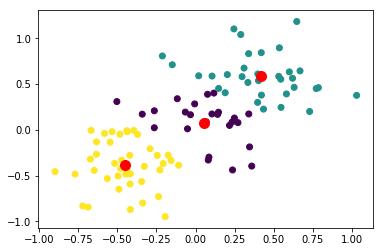

In [27]:
plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", s=100)

### 4 clusters

In [28]:
labels, centroids = kmeans(data, 4)

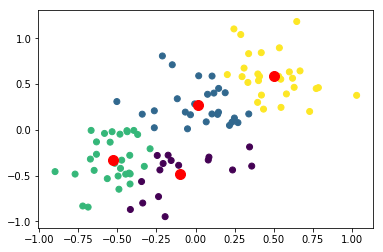

In [29]:
plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", s=100)

### 5 clusters

In [30]:
labels, centroids = kmeans(data, 5)

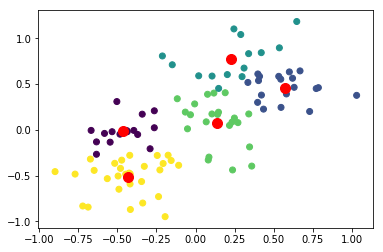

In [31]:
plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", s=100)

## Elbow method

In [36]:
def dunn_index(k):
    labels, centroids = kmeans(data, k)
    smallest_intracluster, minpair = separation(data, labels, k)
    largest_intracluster, maxpair = largest_intracluster_distance(data, labels, k)
    return smallest_intracluster / largest_intracluster

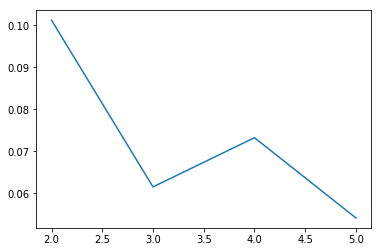

In [37]:
K = np.array([2, 3, 4, 5])
C = np.empty((K.shape[0]))
i = 0
for k in K:
    C[i] = dunn_index(k)
    i = i + 1
plt.plot(K, C)

## Conclusions

- k-means clustering did a decent job separating datapoints into clusters
- The optimal number of clusters as estimated using elbow method is 2, which is matching the data